In [2]:
""" Import of modules """
import numpy.random as np
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
from scipy import stats
import math
from tqdm import tqdm_notebook as tqdm

""" Initialization """
Npop = 100000 #Population size
parr = numpy.exp(numpy.arange(-24, -14)) #Mutation rate
narr = numpy.exp(numpy.arange(14, 25)) #Cell number
gmean = numpy.array([0, 0.5, 1, 1.5, 2])
gvar = numpy.array([0.5, 1, 2, 4])
growth_rate = np.normal(0.5, 1, Npop) #Growth rate distribution
delta = -numpy.exp(numpy.arange(-7,-1))

ndiv = 10 #Number of cell divisions per year
age = 90 #Lifespan
time = ndiv*age #Duration of the simulation
wts = numpy.array([0.013818048555027355, 0.0553159434123515, 0.07253241028642805, 0.07303103455912367, 0.07216711636515384, 0.06647847243710951, 0.06452984736662379, 0.07104508339877749, 0.08076197744193335, 0.08185169462960405, 0.07211714069611326, 0.06271758577923968, 0.048454493422914295, 0.038794489715138394, 0.034263609991378986, 0.03177168658747205, 0.026997999757072733, 0.017842803104216928, 0.01550856249432107]) #Weights from the US 2000 standard population
n_class = len(wts)
crc, cmc, crr, ct = numpy.zeros(len(delta)*age).reshape(len(delta),age), numpy.zeros(len(delta)*age).reshape(len(delta),age), numpy.zeros(len(delta)*age).reshape(len(delta),age), numpy.zeros(len(delta)*Npop).reshape(len(delta),Npop)
aa_rate = numpy.zeros(len(delta))
gc, cmut = [[]], [[]]

""" Main simulation """
# np_flag = 0
# for p in tqdm(parr, desc='Mutation rate', leave=False):

flag = 0
for d in tqdm(delta, desc='delta', leave=False):
    n = narr[3]
    p = parr[3]
    cancer_count = numpy.zeros(age) #Age-wise incidence of cancer
    num_surv = numpy.zeros(age) #Number of survivors in each age/generation
    cancer_fract = numpy.zeros(age) #Normalized incidence of cancer
    cumul_count = numpy.zeros(age) #Cumulative count of cancer
    crude_rate = numpy.zeros(age) #Calculated age-wise incidence per 100000
    cancer_time = numpy.zeros(Npop)
    mut_can, gcan = [], []
    muller_ratchet = numpy.array([d]*time)*n*p
    #     cancer_time = numpy.zeros(Npop)
    #         g_initial = []
    # age_rate=numpy.zeros((19)) #Age-specific rates adjusted to the US 2000 standard population

    for j in tqdm(range(Npop), desc='Npop', leave=False):
        garr = numpy.array([growth_rate[j]]*time, dtype=float)
        t=0 #Index to track time
        n_mut=[0]*time
        m=0 #Initial mutant cell population
        m_hold = 0
        p_mut=1-((1-p)**n) #Initial probabiltiy of first mutation arising in the population
        a=0 #Current age

        for t in range(time):

            n_mut[t]=n_mut[t-1 or 0]
            garr[t] = garr[t-1 or 0] + muller_ratchet[t]

            if p_mut > np.random_sample(): #New mutant population
                m=1
                n_mut[t]+=1
                p_mut=1-((1-p)**m)
                garr[t] = garr[0]

            elif garr[t] < 0: #Negative growth is physiologically undefined and mathematically unbounded
                break

            elif n_mut[t-1 or t] > 0: #Growth of existing mutant or normal population, as the case may be
                m_inc = math.copysign(1.0, garr[t])*math.fabs(m*garr[t]*(1-(m/n)))
                m += m_inc
                p_mut=1-((1-p)**m)
            
#             elif garr[t] < 0:
#                 pass


            if n_mut[t] == 5: #Recording actual cancer cases
                cancer_count[int(t/ndiv)] += 1
                gcan.append(garr[0])
                mut_can.append(n_mut)
                cancer_time[j] = int(t/ndiv)
                break

    """ Calculations """
    cumul_count = cancer_count.cumsum()

    num_surv = numpy.array([Npop]*age, dtype=float)
    num_surv[1:] -= cumul_count[:-1]

    cancer_fract = cancer_count/(cancer_count+num_surv)
    crude_rate = cancer_fract*100000

    cc_bin, crr_bin, cf_bin, age_rate = numpy.zeros(n_class), numpy.zeros(n_class), numpy.zeros(n_class), numpy.zeros(n_class)
    age_rate[0]=cancer_count[0]
    age_rate[1]=sum(cancer_count[1:4])
    age_rate[-1]=sum(cancer_count[85:len(cancer_count)])
    for i in range(2,18):
        age_rate[i]=sum(cancer_count[(5*(i-1)):(5*(i-1)+4)])

    numsurv_bin = numpy.array([Npop]*n_class,dtype=float)
    cc_bin = age_rate.cumsum()
    numsurv_bin[1:] -= cc_bin[:-1]

    cf_bin = age_rate/(age_rate+cc_bin)
    crr_bin = cf_bin*100000

#     gcan = numpy.asarray(gcan)
#     mut_can = numpy.asarray(mut_can)
    gc.append(gcan)
    cmut.append(mut_can)
    ct[flag] = cancer_time[:]
    crc[flag] = cancer_count[:]
    cmc[flag] = cumul_count[:]
    crr[flag] = crude_rate[:]
    aa_rate[flag] = (crr_bin*wts).sum()
    flag += 1
    

gc = numpy.asarray(gc)
cmut = numpy.asarray(cmut)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/home/iiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


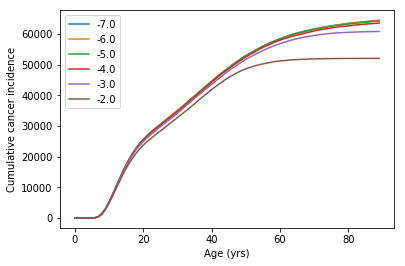

In [11]:
for i, l in zip(cmc, numpy.log(numpy.abs(delta))):
    plt.plot(i.T, label=l)
plt.legend()
plt.xlabel('Age (yrs)')
plt.ylabel('Cumulative cancer incidence')
plt.savefig('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/figures/20Aug2018/linear_v2_cumulative_rate_delta.svg')

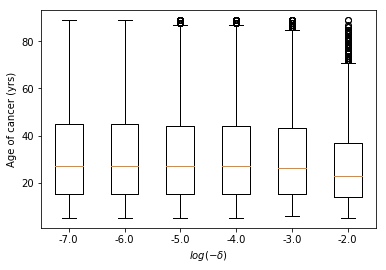

In [21]:
plt.boxplot([ct[i][ct[i].nonzero()] for i in range(len(ct))], positions=numpy.log(numpy.abs(delta)), manage_xticks=True)
plt.xticks(numpy.log(numpy.abs(delta)))
plt.xlabel(r'$log(-\delta)$')
plt.ylabel('Age of cancer (yrs)')
plt.savefig('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/figures/20Aug2018/linear_v2_cancer_time_delta.svg')

In [13]:
df_crc = pd.DataFrame(crc, index = delta)
df_crc.index.names = ['Delta']
df_crc.columns.names = ['Age']
df_crc.to_excel('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/data/20Aug2018/linear_v2_raw_counts_delta.xlsx')

df_cc = pd.DataFrame(cmc, index = delta)
df_cc.index.names = ['Delta']
df_cc.columns.names = ['Age']
df_cc.to_excel('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/data/20Aug2018/linear_v2_cumulative_delta.xlsx')

df_crr = pd.DataFrame(cmc, index = delta)
df_crr.index.names = ['Delta']
df_crr.columns.names = ['Age']
df_crr.to_excel('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/data/20Aug2018/linear_v2_crude_delta.xlsx')

In [14]:
half_age_delta = numpy.zeros(len(delta))
for i in range(len(delta)):
    half_age_delta[i] = numpy.less_equal(cmc[i], cmc[i,-1]/2).sum()

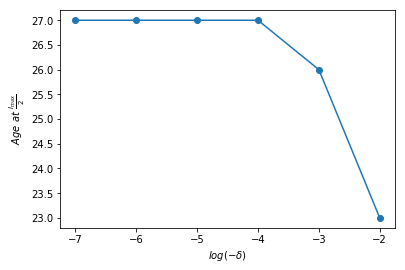

In [15]:
plt.plot(numpy.log(-delta), half_age_delta, 'o-')
plt.xlabel(r'$log(-\delta)$')
plt.ylabel(r'$Age\ at\ \frac{I_{max}}{2}$')
plt.savefig('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/figures/20Aug2018/linear_v2_halfmax_age_delta.svg')

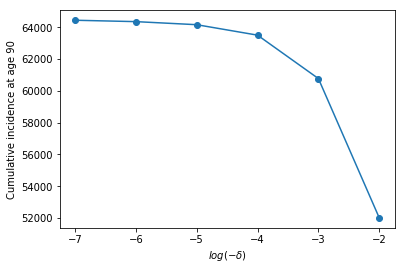

In [16]:
plt.plot(numpy.log(-delta), cmc[:,-1], 'o-')
plt.xlabel(r'$log(-\delta)$')
plt.ylabel('Cumulative incidence at age 90')
plt.savefig('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/figures/20Aug2018/linear_v2_incidence_at_90_delta.svg')

In [17]:
gc = gc[1:]
gd1 = numpy.asarray(gc[0])
gd2 = numpy.asarray(gc[1])
gd3 = numpy.asarray(gc[2])
gd4 = numpy.asarray(gc[3])
gd5 = numpy.asarray(gc[4])
gd6 = numpy.asarray(gc[5])

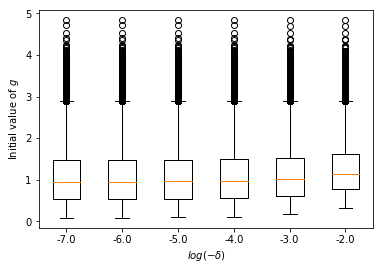

In [23]:
plt.boxplot([gd1, gd2, gd3, gd4, gd5, gd6], positions=numpy.log(numpy.abs(delta)), manage_xticks=True)
plt.xticks(numpy.log(numpy.abs(delta)))
plt.xlabel(r'$log(-\delta)$')
plt.ylabel(r'Initial value of $g$')
plt.savefig('/home/iiser/PhD/Research/cancer_project/cancer_incidence_model/linear_model/muller_ratchet/figures/20Aug2018/linear_v2_g_initial_delta.svg')